(quickstart-df)=

# Quickstart: Data Frames

This quickstart provides a quick walkthrough of the `Meerkat` data frame, which allows users to interact with unstructured data alongside standard tabular data.

In [1]:
import os
import meerkat as mk
import numpy as np

## 💾 Downloading the data
First, we'll download some data to explore. We're going to use the [Imagenette dataset](https://github.com/fastai/imagenette#image%E7%BD%91), a small subset of the original [ImageNet](https://www.image-net.org/update-mar-11-2021.php).  This dataset is made up of 10 classes (e.g. "garbage truck", "gas pump", "golf ball").
- Download time: < 1 minute
- Download size: 130M

In addition to downloading the data, `download_imagnette` prepares a CSV, `imagenette.csv`, with a row for each image.

In [2]:
from meerkat.datasets.imagenette import download_imagenette

dataset_dir = "./downloads"
os.makedirs(dataset_dir, exist_ok=True)
download_imagenette(dataset_dir, overwrite=True)

Downloading:   0%|          | 0.00/99.0M [00:00<?, ?B/s]

Extracting tar archive, this may take a few minutes...


Let's take a look at the CSV.

In [3]:
!head -n 5 downloads/imagenette2-160/imagenette.csv

label,split,img_path
cassette player,train,train/n02979186/n02979186_9036.JPEG
cassette player,train,train/n02979186/n02979186_11957.JPEG
cassette player,train,train/n02979186/n02979186_9715.JPEG
cassette player,train,train/n02979186/n02979186_21736.JPEG


Next, we'll load it into a Meerkat `DataFrame`.

## 📸 Creating an image `DataFrame`
*For more information on creating DataFrames from various data sources, see the user guide section on {ref}`guide/dataframe/io`.*

Meerkat's core contribution is the DataFrame, a simple columnar data abstraction. The Meerkat DataFrame can house columns of arbitrary type – from integers and strings to complex, high-dimensional objects like videos, images, medical volumes and graphs.

We're going to build a `DataFrame` out of the `imagenette.csv` file from the download above.

,label,split,img_path,img
0,cassette player,train,train/n02979186/n02979186_9036.JPEG,
1,cassette player,train,train/n02979186/n02979186_11957.JPEG,
2,cassette player,train,train/n02979186/n02979186_9715.JPEG,
3,cassette player,train,train/n02979186/n02979186_21736.JPEG,
4,cassette player,train,train/n02979186/ILSVRC2012_val_00046953.JPEG,
...,...,...,...,...
13389,gas pump,valid,val/n03425413/n03425413_17521.JPEG,
13390,gas pump,valid,val/n03425413/n03425413_20711.JPEG,
13391,gas pump,valid,val/n03425413/n03425413_19050.JPEG,
13392,gas pump,valid,val/n03425413/n03425413_13831.JPEG,

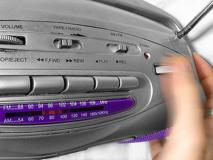
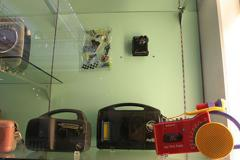
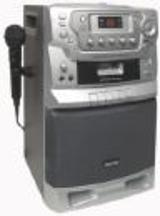
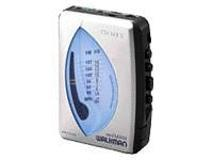
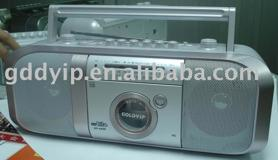
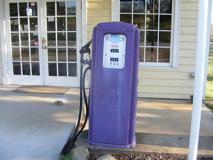
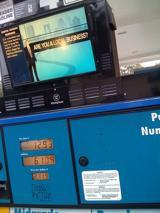
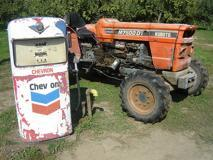
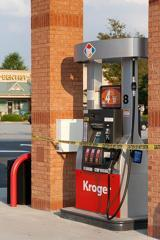
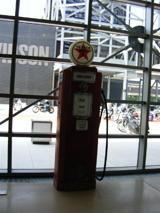

In [4]:
# Create a `DataFrame`
df = mk.from_csv("./downloads/imagenette2-160/imagenette.csv")

# Create an `ImageColumn`` and add it to the `DataFrame`
df["img"] = mk.image(
    df["img_path"], 
    base_dir=os.path.join(dataset_dir, "imagenette2-160")
)
df

The call to `head` shows the first few rows in the `DataFrame`. You can see that there are a few metadata columns, as well as the "img" column we added in.

## 🗂 Selecting data
*For more information see the user guide section on {ref}`guide/dataframe/selection`.*

When we create an `ImageColumn` we don't load the images into memory. Instead, `ImageColumn` keeps track of all those filepaths we passed in and only loads the images when they are needed. 

When we select a row of the `ImageColumn`, we get an instance `FileCell` back. A `FileCell` is an object that holds everything we need to materialize the cell (e.g. the filepath to the image and the loading function), but stops just short of doing so.

In [5]:
img_cell = df["img"][0]
print(f"Indexing the `ImageColumn` returns an object of type: {type(img_cell)}.")

Indexing the `ImageColumn` returns an object of type: <class 'meerkat.columns.deferred.file.FileCell'>.


To actually materialize the image, we simply call the cell.

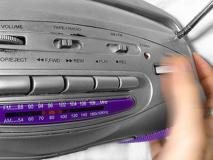

In [6]:
img = img_cell()
img

We can subselect a **batch** of images by indexing with a slice.  Notice that this returns a smaller {class}`~meerkat.DataFrame`.

Indexing a slice of the `ImageColumn` returns a: <class 'meerkat.columns.deferred.file.FileColumn'>.


,(FileColumn)
0,
1,
2,

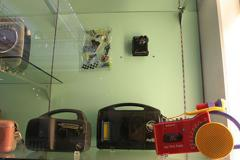
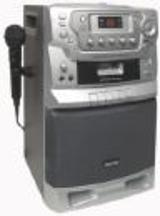
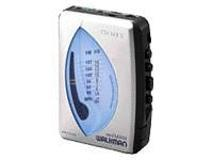

In [7]:
imgs = df["img"][1:4]
print(f"Indexing a slice of the `ImageColumn` returns a: {type(imgs)}.")
imgs

The whole batch of images can be loaded together by calling the column. 
```
imgs();
```

One can load multiple rows using any one of following indexing schemes:
- **Slice indexing**: _e.g._ `column[4:10]`
- **Integer array indexing**: _e.g._ `column[[0, 4, 6, 11]]`
- **Boolean array indexing**: _e.g._ `column[np.array([True, False, False ..., True, False])]`

### 📎 _Aside_: `ImageColumn` under the hood, `DeferredColumn`.

If you check out the implementation of `ImageColumn` (at [meerkat/column/image_column.py](https://github.com/HazyResearch/meerkat/blob/main/meerkat/column/image_column.py)), you'll notice that it's a super simple subclass of `DeferredColumn`. 

_What's a `DeferredColumn`?_
In `meerkat`, high-dimensional data types like images and videos are typically stored in a `DeferredColumn`. A  `DeferredColumn` wraps around another column and lazily applies a function to it's content as it is indexed. Consider the following example, where we create a simple `meerkat` column...

In [8]:
  col = mk.column([0,1,2])

...and wrap it in a deferred column.
```
  dcol = col.defer(fn=lambda x: x + 10)
  dcol[1]()  # the function is only called at this point!
```
Critically, the function inside a lambda column is only called at the time the column is called! This is very useful for columns with large data types that we don't want to load all into memory at once. For example, we could create a `DeferredColumn` that lazily loads images...
```
  >>> filepath_col = mk.PandasSeriesColumn(["path/to/image0.jpg", ...])
  >>> img_col = filepath.defer(lambda x: load_image(x))
```
An `ImageColumn` is a just a `DeferredColumn` like this one, with a few more bells and whistles!

## 🛠 Applying operations over the DataFrame.

When analyzing data, we often perform operations on each example in our dataset (e.g. compute a model's prediction on each example, tokenize each sentence, compute a model's embedding for each example) and store them. The `DataFrame` makes it easy to perform these operations:  
- Produce new columns (via `DataFrame.map`)
- Produce new columns and store the columns alongside the original data (via `DataFrame.update`)
- Extract an important subset of the datset (via `DataFrame.filter`).   

Under the hood, dataloading is multiprocessed so that costly I/O doesn't bottleneck our computation.

Let's start by filtering the `DataFrame` down to the examples in the validation set.

In [9]:
valid_df = df.filter(lambda split: split == "valid")

### 🫐  Using `DataFrame.map` to compute average intensity of the blue color channel in the images.

To demonstrate the utility of the `map` operation, we'll explore the relationship between the "blueness" of an image and the class of the image. 

We'll quantify the "blueness" of each image by simply computing the mean intensity of the blue color channel. This can be accomplished with a simple `map` operation over the `DataFrame`:

In [10]:
blue_col = valid_df.map(
    lambda img: np.array(img)[:, :, 2].mean(), 
    num_workers=2
)

# Add the intensities as a new column in the `DataFrame` 
valid_df["avg_blue"] = blue_col

### 🪂 vs. ⛳️
Next, we'll explore the relationship between blueness and the class label of the image. To do so, we'll compare the blue intensity distribution of images labeled "parachute" to the distribution of of images labeled "golf ball".
Using the [`seaborn`](https://seaborn.pydata.org/installing.html) plotting package and our `DataFrame`, this can be accomplished in one line:

/home/runner/work/meerkat/meerkat/meerkat/dataframe.py:836: UserWarning: Could not convert column img of type <class 'meerkat.columns.deferred.file.FileColumn'>, it will be dropped from the output.
  warnings.warn(


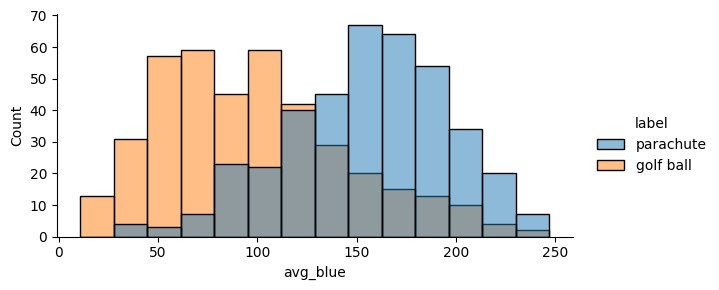

In [11]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns

plot_df = valid_df[np.isin(valid_df["label"], ["golf ball", "parachute"])]
sns.displot(
    data=plot_df.to_pandas(), 
    x="avg_blue", 
    hue="label", 
    height=3, 
    aspect=2
)

In [12]:
valid_df["img"][int(np.argmax(valid_df["avg_blue"]))]

FileCell(fn=<meerkat.columns.deferred.file.FileLoader object at 0x7ffba9579850>)

## 📉 ML with images in `meerkat`.

Let's do some machine learning on our Imagenette `DataFrame`.
We'll take a resnet18 pretrained on the full ImageNet dataset, perform inference on the validation set, and analyze the model's predictions and activations. 

The cell below downloads the model..

In [13]:
import torch
from torchvision.models import resnet18
import torchvision.transforms as transforms
model = resnet18(pretrained=True)

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/runner/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### 💈  Applying a transform to the images.
In order to do inference, we'll need to create a _new_ {class}`~meerkat.DeferredColumn`. The `ImageColumn` we defined above (_i.e._ `"img_path"`), does not apply any transforms after loading and simply returns a PIL image. Before passing the images through the model, we need to convert the PIL image to a `torch.Tensor` and normalize the color channels (along with a few other transformations). 

Note: the transforms defined below are the same as the ones used by torchvision, see [here](https://github.com/pytorch/examples/blob/cbb760d5e50a03df667cdc32a61f75ac28e11cbf/imagenet/main.py#L225). 

In the cell below, we specify a transform when creating the `ImageColumn`.

In [14]:
# Define transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
])

# Create new column with transform 
valid_df["input"] = valid_df["img"].defer(transform)

Notice that indexing this new column returns a `torch.Tensor`, not a PIL image...

In [15]:
img = valid_df["input"][0]()
print(f"Indexing the `ImageColumn` returns an object of type: {type(img)}.")

Indexing the `ImageColumn` returns an object of type: <class 'torch.Tensor'>.


... and that indexing a slice of this new column returns a {class}`~meerkat.TensorColumn`.

In [16]:
col = img = valid_df["input"][:3]()
print(f"Indexing a slice of the `ImageColumn` returns an object of type: {type(img)}.")
col

Indexing a slice of the `ImageColumn` returns an object of type: <class 'meerkat.columns.tensor.torch.TorchTensorColumn'>.


,(TorchTensorColumn)
0,"torch.Tensor(shape=torch.Size([3, 224, 224]))"
1,"torch.Tensor(shape=torch.Size([3, 224, 224]))"
2,"torch.Tensor(shape=torch.Size([3, 224, 224]))"


Let's see what the full `DataFrame` looks like now.

,label,split,img_path,img,avg_blue,input
0,cassette player,valid,val/n02979186/n02979186_8971.JPEG,,185.601094,"tensor([[[2.2318, 2.2318, 2.2318, ..., 2.2318, 2.2318, 2.2318], [2.2318, 2.2318, 2.2318, ...,..."
1,cassette player,valid,val/n02979186/n02979186_14550.JPEG,,62.169894,"tensor([[[-1.3987, -1.4329, -1.4329, ..., 0.5193, 0.5193, 0.4508], [-1.3987, -1.4158, -1.4158,..."
2,cassette player,valid,val/n02979186/n02979186_11971.JPEG,,130.143574,"tensor([[[1.2385, 1.3584, 1.3755, ..., 0.6392, 0.6049, 0.6906], [1.1529, 1.2557, 1.3070, ...,..."
3,cassette player,valid,val/n02979186/n02979186_11550.JPEG,,32.200174,"tensor([[[-0.4739, -0.4397, -0.3198, ..., 2.0434, 2.0263, 1.9920], [-0.3883, -0.3541, -0.2856,..."
4,cassette player,valid,val/n02979186/n02979186_8751.JPEG,,57.239097,"tensor([[[ 0.1254, 0.1254, 0.1254, ..., -0.0458, -0.0458, -0.0458], [ 0.1254, 0.1254, 0.1254,..."

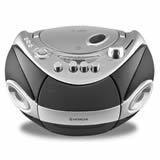
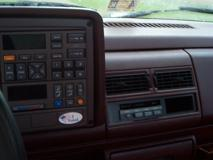
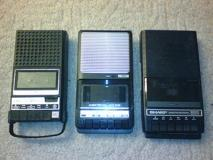
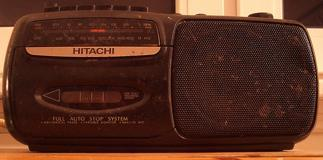
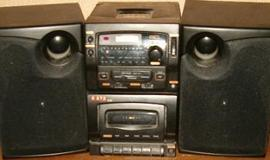

In [17]:
valid_df.head()

### 💫 Computing model predictions and activations.
We'd like to perform inference and extract:
  
1. Output predictions  
2. Output class probabilities  
3. Model activations 

Note: in order to extract model activations, we'll need to use a [PyTorch forward hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) and register it on the final layer of the ResNet. Forward hooks are just functions that get executed on the forward pass of a `torch.nn.Module`.

In [18]:
# Define forward hook in ActivationExtractor class
class ActivationExtractor:
    """Extracting activations a targetted intermediate layer"""

    def __init__(self):
        self.activation = None

    def forward_hook(self, module, input, output):
        self.activation = output

# Register forward hook
extractor = ActivationExtractor()
model.layer4.register_forward_hook(extractor.forward_hook);

We want to apply a forward pass to each image in the `DataFrame` and store the outputs as new columns: `DataFrame.map` is perfectly suited for this task.

In [19]:
# 1. Move the model to GPU, if available
# device = 0
device = "cpu"
model.to(device).eval()

# 2. Define a function that runs a forward pass over a batch 
@torch.no_grad()
def predict(input: mk.TensorColumn):
    x: torch.Tensor = input.data.to(device)  # We get the underlying torch tensor with `data` and move to GPU 
    out: torch.Tensor = model(x)  # Run forward pass

    # Return a dictionary with one key for each of the new columns. Each value in the
    # dictionary should have the same length as the batch. 
    return {
        "pred": out.cpu().numpy().argmax(axis=-1),
        "probs": torch.softmax(out, axis=-1).cpu(),
        "activation": extractor.activation.mean(dim=[-1,-2]).cpu()
    }
# 3. Apply the update. Note that the `predict` function operates on batches, so we set 
# `batched=True`. Also, the `predict` function only accesses the "input" column, by 
# specifying that here we instruct update to only load that one column and skip others 
pred_df = valid_df.map(function=predict, is_batched_fn=True, batch_size=32)
valid_df = mk.concat([valid_df, pred_df], axis="columns")

The predictions, output probabilities, and activations are now stored alongside the examples in the `DataFrame`.

In [20]:
valid_df[["label_idx", "input", "pred", "probs", "activation"]].head()

KeyError: "DataFrame does not have columns {'label_idx'}"

### 🎯  Computing metrics and analyzing performance. 

Computing statistics on Meerkat `DataFrames` is straightforward because standard NumPy operators and functions can be applied directly to a `NumpyArrayColumn`. We take advantage of this below to compute the accuracy of the model.

In [ ]:
valid_df["correct"] = valid_df["pred"] == valid_df["label_idx"].data
accuracy = valid_df["correct"].mean()
print(f"Micro accuracy across the ten Imagenette classes: {accuracy:0.3}")

Furthermore, since the `DataFrame` is naturally converted to a Pandas DataFrame, it's easy to use data visualization tools that interface with Pandas (_e.g._ seaborn, bokeh).

In [ ]:
## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(data=valid_df.to_pandas(), y="label", x="correct");

### 🔎  Exploring model activations.
To better understand the behavior of our model, we'll explore the activations of the final convolutional layer of the ResNet. Recall that when we performed our forward pass, we extracted these activations and stored them in a new column called `"activation"`.

Unlike the the `NumpyArrayColumn`s we've been working with so far, the activation column has an additional dimension of size 512.

To visualize the activations, we'll use a dimensionality reduction technique ([UMAP](https://umap-learn.readthedocs.io/en/latest/)) to embed the activations in two dimensions. We'll store these embeddings in two new columns "umap_0" and "umap_1".

In [ ]:
## OPTIONAL: this cell requires the umap dependency: https://umap-learn.readthedocs.io/en/latest/
!pip install umap-learn
from umap import UMAP

# 1. Compute UMAP embedding
reducer = UMAP()
embs = reducer.fit_transform(valid_df["activation"])

# 2. Add the embedding to the DataFrame as two new columns 
valid_df["umap_0"] = embs[:, 0]
valid_df["umap_1"] = embs[:, 1]

## OPTIONAL: this cell requires the seaborn dependency: https://seaborn.pydata.org/installing.html 
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=valid_df.to_pandas(), x="umap_0", y="umap_1", hue="label");
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## 💾  Writing a `DataFrame` to disk. 
Finally, we can write the updated `DataFrame`, with all the activations and predictions included, to disk for later use.  

`DataFrame` size on disk: 25MB

On disk, the `DataFrame` is stored in a directory at the path passed to `DataFrame.write`. Within that directory, each column is stored separately. This allows us to read only a subset of columns from DataFrame on disk. Use the file explorer to the left to further expore the file structure of the `DataFrame`.  
```
valid_df
|  +-- meta.yml   
|  +-- state.dill  
|  +-- columns
   |   +-- activation
   |   +-- avg_blue
   |   +-- correct
   |   ...
   |   +-- umap_1
```

In [ ]:
valid_df.write(os.path.join(dataset_dir, "valid_df"))

In [ ]:
valid_df = mk.read(os.path.join(dataset_dir, "valid_df"))